In [1]:
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Embedding, Activation
from keras.layers import Dropout, SpatialDropout1D
from keras.layers import LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
import pandas as pd
import numpy as np
import nltk
import gensim
import emoji
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import re
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/huiyiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
stop_words = stopwords.words('english')

In [3]:
def remove_punct(s):
    punct_pattern = re.compile(r'[^\w\s]')
    no_punct = punct_pattern.sub(r'', s)
    return no_punct

def remove_emoji(string):
    allchars = [str for str in string]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI['en']]
    clean_text = ' '.join([str for str in string.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [4]:
def tweet_preprocessing(tweet):
    temp = []
    tokens = list(nltk.word_tokenize(tweet.strip()))
    for t in tokens:
        if t in stop_words:
            continue
        token = remove_emoji(t)
        token = remove_punct(token).strip()
        if token:
            temp.append(token)
    return temp

def data_preprocessing(data, test=False):
    texts = []
    labels = []
    for i in tqdm(data.itertuples(), total=len(data)):
        temp = tweet_preprocessing(i.tidyTweet)
        texts.append(temp)
        if not test:
            labels.append(i.Label)
            if i.Label == 1.0:
                texts.extend([temp] * 2)
                labels.extend([i.Label] * 2)
    if not test:
        assert len(texts) == len(labels)
        return texts, labels
    else:
        return texts

In [5]:
train_df = pd.read_csv('../dataset.csv')
train_df = train_df.dropna(subset=['tidyTweet', 'Label'])
texts, labels = data_preprocessing(train_df)

In [6]:
encoder = preprocessing.LabelEncoder()
encoder_y = encoder.fit_transform(labels)
y_cate = to_categorical(encoder_y, num_classes=len(set(encoder_y)))

In [7]:
## 构造包含所有词语的list，以及初始化 “词语-序号”字典 和 “词向量”矩阵
def build_word2vec_dict(w2v_model):
    vocab_list = list(w2v_model.wv.key_to_index.keys())

    # 初始化存储所有向量的大矩阵
    embeddings_matrix = np.zeros((len(vocab_list), w2v_model.vector_size))
    ## 填充上述的字典和矩阵
    for i in range(len(vocab_list)):
        word = vocab_list[i]
        embeddings_matrix[i] =w2v_model.wv[word]
    return len(vocab_list), embeddings_matrix

def generate_data(texts, w2v_model, maxlen):
    X = []
    words_dict = w2v_model.wv.key_to_index
    for text in texts:
        temp = []
        for word in text:
            if word in words_dict:
                temp.append(words_dict[word])
            else:
                temp.append(1)
        if len(temp) < maxlen:
            temp += [0] * (maxlen - len(temp))
        else:
            temp = temp[:maxlen]
        X.append(temp)
    X = np.array(X)
    return X


In [8]:
maxlen = 128

w2v_model = gensim.models.Word2Vec(
    texts,
    vector_size=300,
    window=5,
    min_count=1,
    workers=5
)

vocab_size, embeddings_matrix = build_word2vec_dict(w2v_model)
X = generate_data(texts, w2v_model, maxlen)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_cate,
    stratify=y_cate,
    test_size=0.2,
    random_state=1
)

In [31]:
# 模型结构：词嵌入-dropout-LSTM-全连接-dropout-全连接
model = Sequential()
model.add(
    Embedding(vocab_size,
              300,
              weights=[embeddings_matrix],
              input_length=maxlen,
              trainable=True))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.2)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 128, 300)          9284100   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 128, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_6 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 100)               60100     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                

In [22]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [32]:
filepath = 'lstm_weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=3,
                          verbose=1,
                          mode='max',
                          restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              metrics=['accuracy'])

history = model.fit(X_train,
                    y=y_train,
                    batch_size=128,
                    epochs=16,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/16
110/110 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5462
Epoch 1: val_accuracy improved from -inf to 0.61319, saving model to lstm_weights.best.hdf5
110/110 [==============================] - 73s 645ms/step - loss: 0.6912 - accuracy: 0.5462 - val_loss: 0.6572 - val_accuracy: 0.6132
Epoch 2/16
110/110 [==============================] - ETA: 0s - loss: 0.6611 - accuracy: 0.6056
Epoch 2: val_accuracy improved from 0.61319 to 0.61890, saving model to lstm_weights.best.hdf5
110/110 [==============================] - 70s 640ms/step - loss: 0.6611 - accuracy: 0.6056 - val_loss: 0.6527 - val_accuracy: 0.6189
Epoch 3/16
110/110 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.6215
Epoch 3: val_accuracy improved from 0.61890 to 0.63089, saving model to lstm_weights.best.hdf5
110/110 [==============================] - 71s 641ms/step - loss: 0.6509 - accuracy: 0.6215 - val_loss: 0.6409 - val_accuracy: 0.6309
Epoch 4/16
110/110 [========

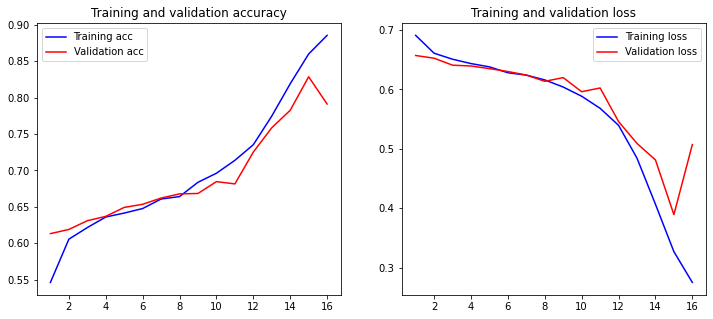

In [33]:
plot_history(history)

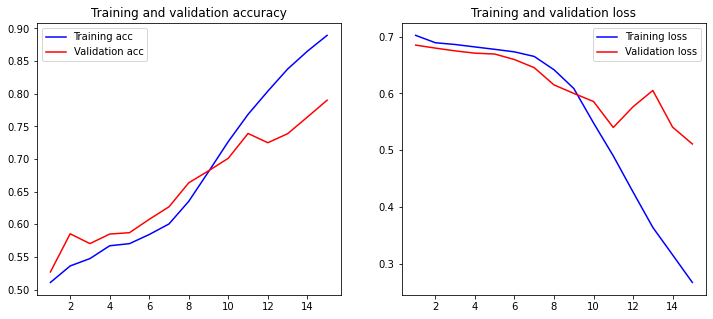

In [33]:
# old
# plot_history(history)

In [37]:
history.history

{'loss': [0.6911534070968628,
  0.6610923409461975,
  0.6509433388710022,
  0.643636167049408,
  0.6380919814109802,
  0.628175675868988,
  0.624180018901825,
  0.6161030530929565,
  0.6041081547737122,
  0.5886096358299255,
  0.5683085322380066,
  0.5396124720573425,
  0.4842868149280548,
  0.40668442845344543,
  0.3268476724624634,
  0.2750071883201599],
 'accuracy': [0.546181321144104,
  0.605567455291748,
  0.621484637260437,
  0.6359742879867554,
  0.6413990259170532,
  0.6476088762283325,
  0.6606709361076355,
  0.6640257239341736,
  0.6836545467376709,
  0.6960742473602295,
  0.7137758731842041,
  0.7351891398429871,
  0.7745181918144226,
  0.8188436627388,
  0.859743058681488,
  0.8852962255477905],
 'val_loss': [0.6572227478027344,
  0.6526795625686646,
  0.6409127116203308,
  0.6395543217658997,
  0.6351053714752197,
  0.6302174925804138,
  0.6243082284927368,
  0.6137427091598511,
  0.6199756264686584,
  0.5962244868278503,
  0.602538526058197,
  0.5459566712379456,
  0.5091

In [36]:
# import json
# with open('istm_train.txt', 'w') as convert_file:
#      convert_file.write(json.dumps(history.history))

In [38]:
model.load_weights(filepath)
preds = np.argmax(model.predict(X_val), axis=-1)
print(f'acc: {accuracy_score(np.argmax(y_val,axis=-1), preds)}')
print(
    f'precision: {precision_score(np.argmax(y_val,axis=-1), preds,average="macro")}'
)
print(
    f'recall: {recall_score(np.argmax(y_val,axis=-1), preds,average="macro")}')
print(f'f1 score: {f1_score(np.argmax(y_val,axis=-1), preds,average="macro")}')
print(classification_report(np.argmax(y_val, axis=-1), preds, digits=4))

acc: 0.8284327719097916
precision: 0.8285917781671428
recall: 0.8285716381561574
f1 score: 0.8284325482053491
              precision    recall  f1-score   support

           0     0.8395    0.8173    0.8282      1773
           1     0.8177    0.8399    0.8286      1730

    accuracy                         0.8284      3503
   macro avg     0.8286    0.8286    0.8284      3503
weighted avg     0.8287    0.8284    0.8284      3503



In [52]:
filepath = 'lstm_weights.best.hdf5'
model = load_model(filepath)

def test_event(file, model, w2v_model, maxlen):
    test_df = pd.read_csv(file)
    test_df = test_df.dropna(subset=['tidyTweet'])
    test_texts = data_preprocessing(test_df, test=True)
    X_test = generate_data(test_texts, w2v_model, maxlen)
    test_preds = np.argmax(model.predict(X_test), axis=-1)
    test_df['predict'] = test_preds
    return test_df

In [53]:
covid_df = test_event('../test_covid_data.csv', model, w2v_model, maxlen)
covid_df.to_csv('covid_result.csv') 

In [54]:
covid_df.groupby('predict').count()

,id,date,tweet,tidyTweet
predict,,,,
0,1294,1294,1294,1294
1,641,641,641,641


In [55]:
truckers_df = test_event('../test_truckers_data.csv', model, w2v_model, maxlen)
truckers_df.to_csv('truckers_result.csv') 

In [56]:
truckers_df.groupby('predict').count()

,id,date,tweet,tidyTweet
predict,,,,
0,1574,1574,1574,1574
1,229,229,229,229
